Companies in dataset: ['AAPL' 'MSFT' 'NFLX' 'GOOG']


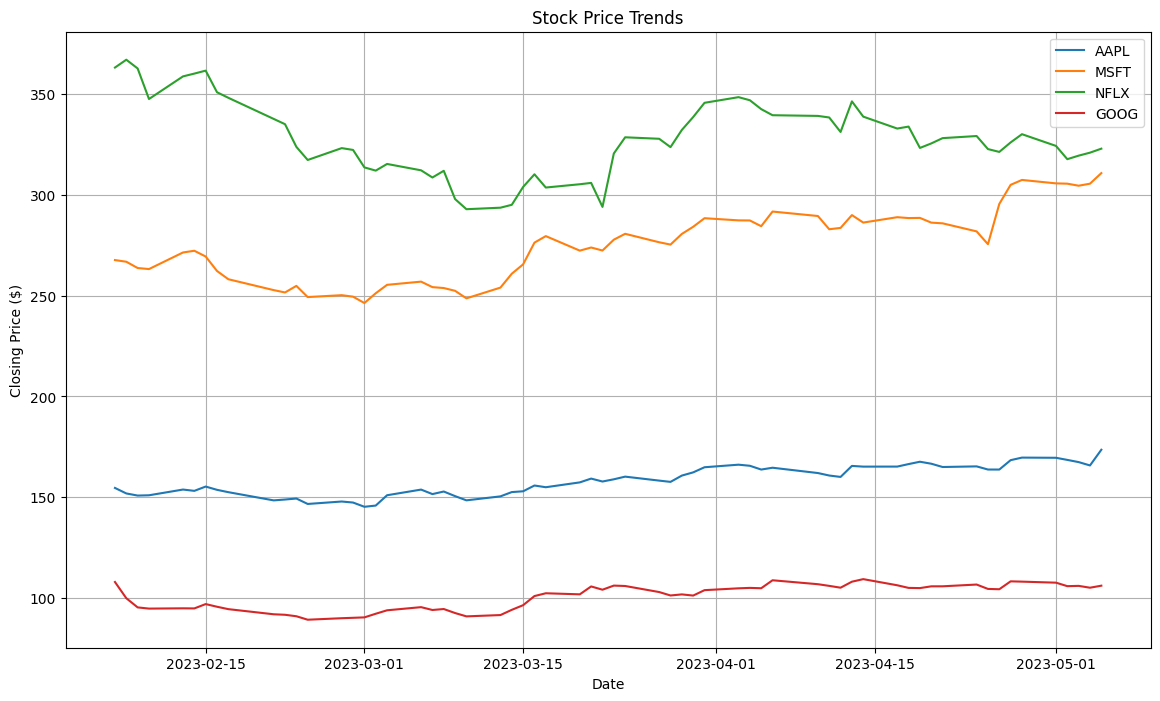

<ipython-input-4-470cfd6b4e28>:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Ticker', group_keys=False).apply(calculate_daily_returns)
<ipython-input-4-470cfd6b4e28>:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Ticker', group_keys=False).apply(calculate_moving_averages)



Volatility:
Ticker
NFLX    2.248134
GOOG    2.071018
MSFT    1.788078
AAPL    1.415222
Name: Daily_Return, dtype: float64


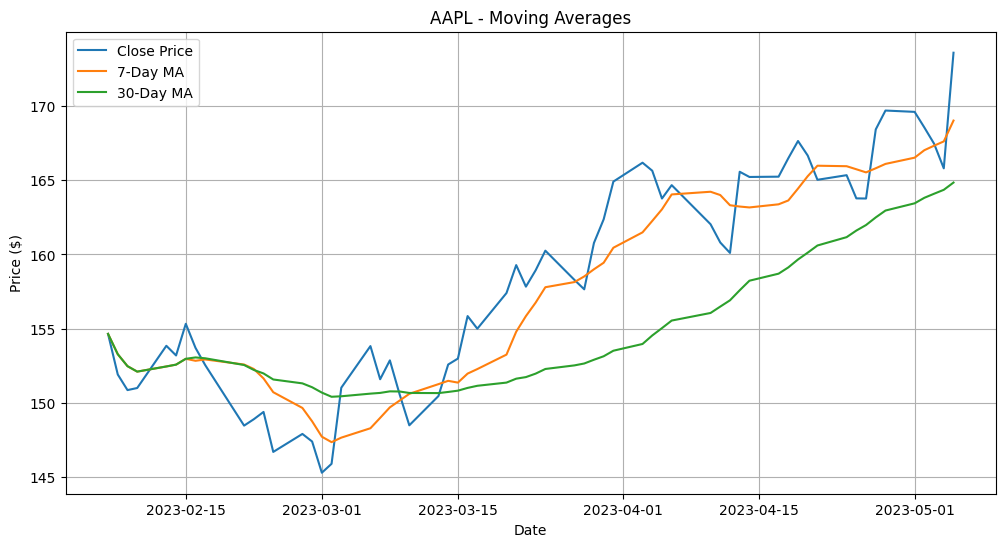

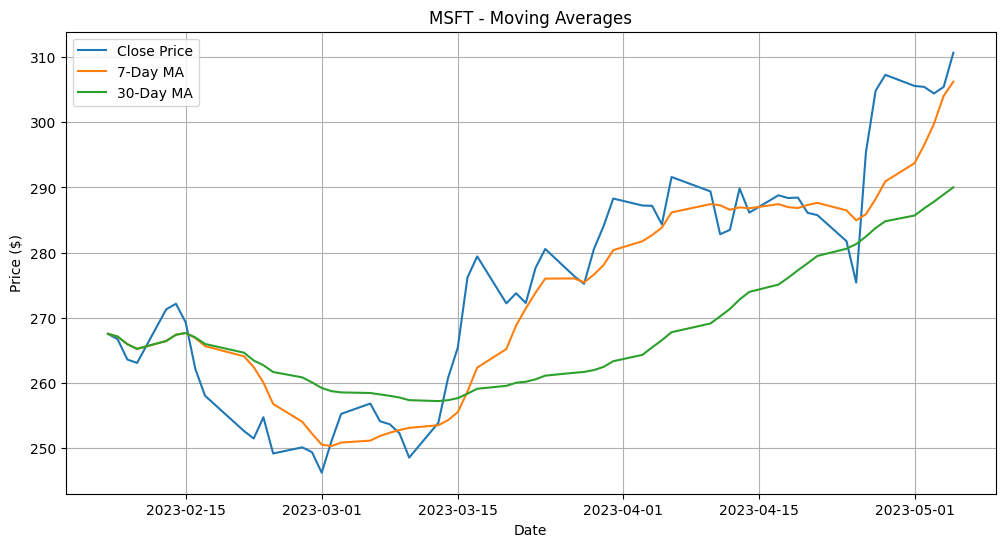

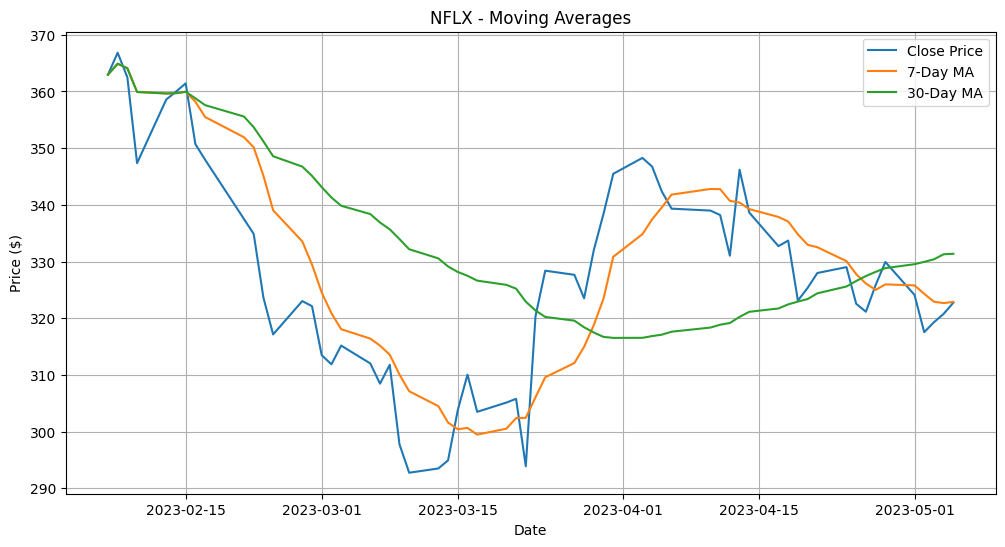

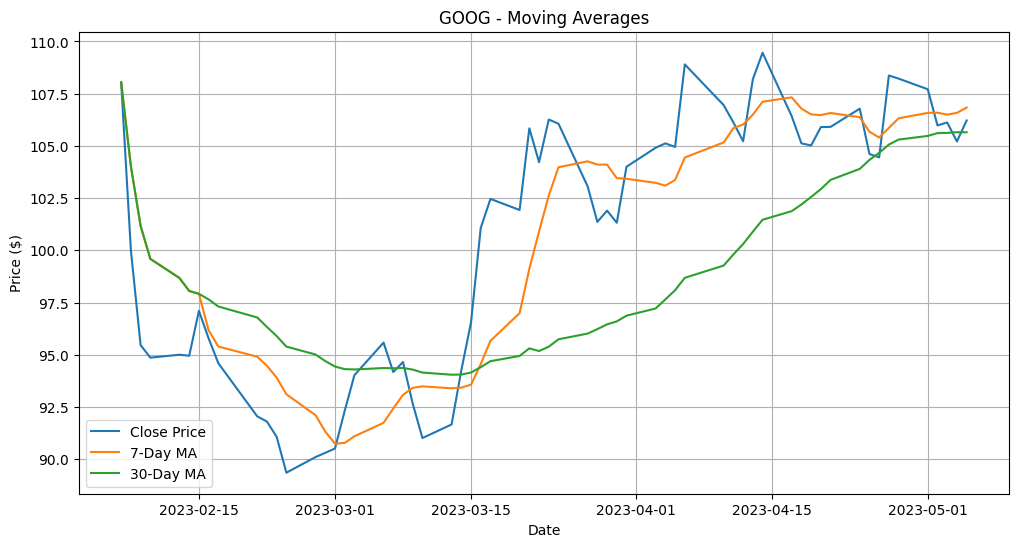

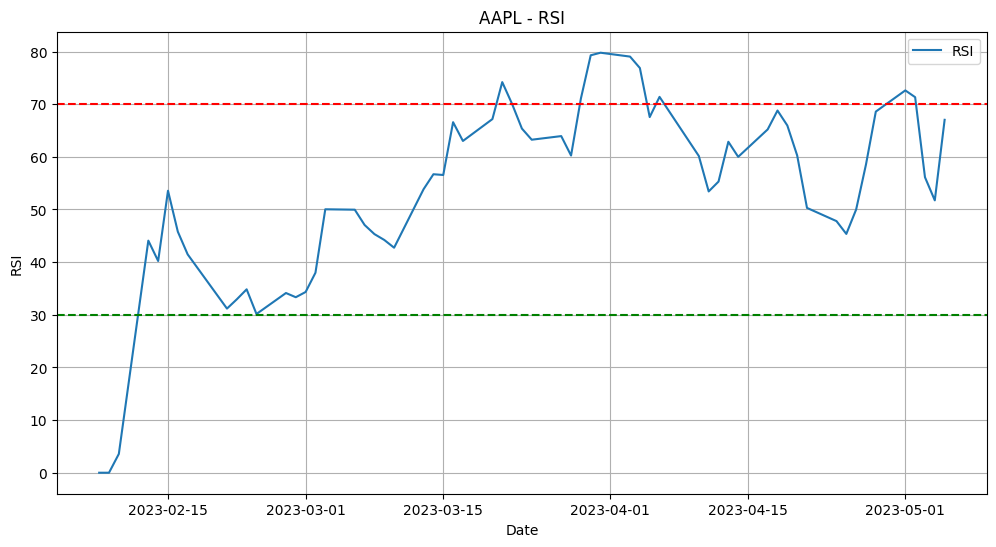

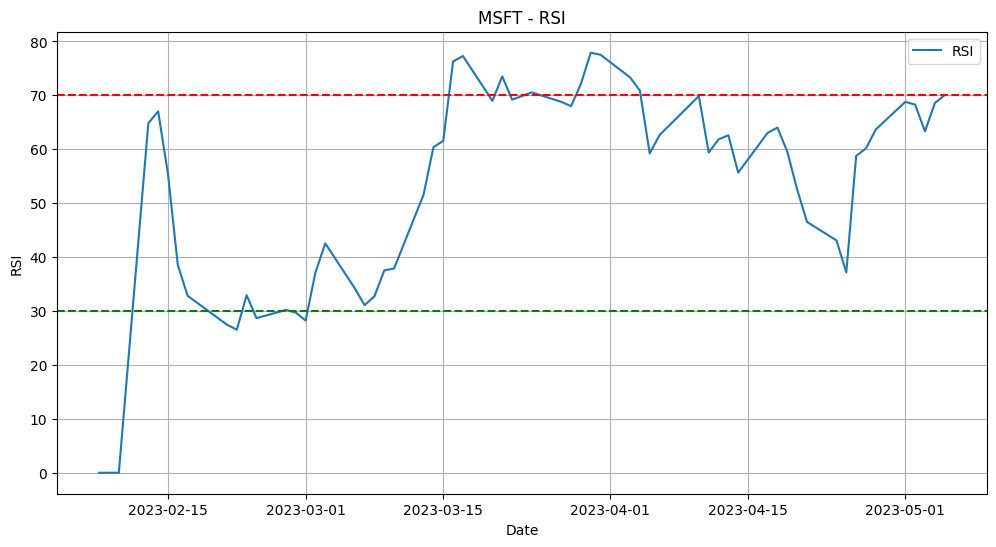

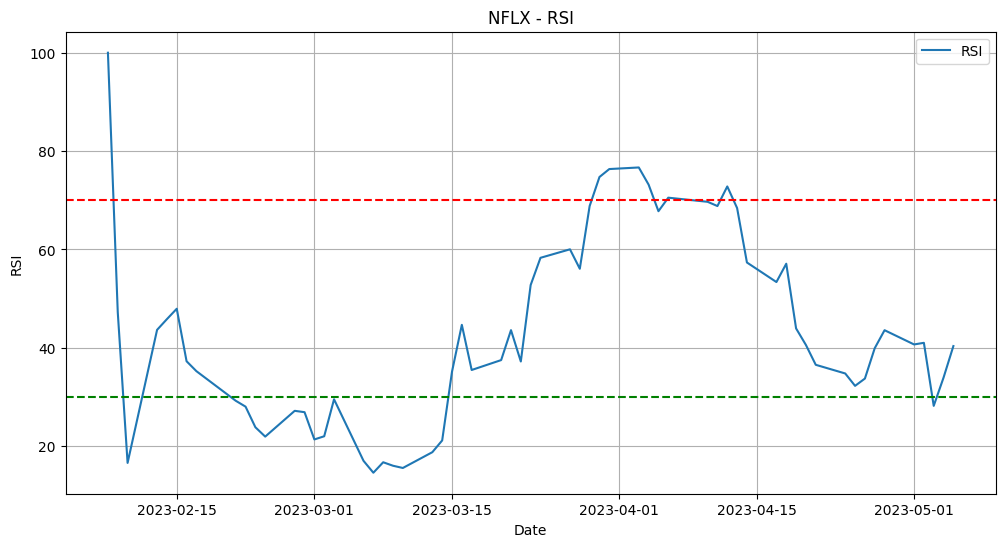

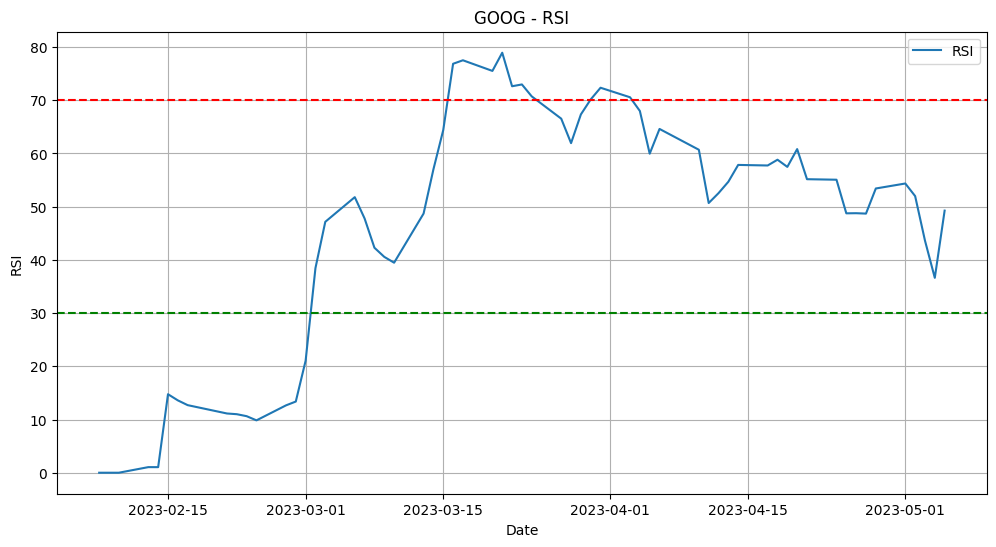

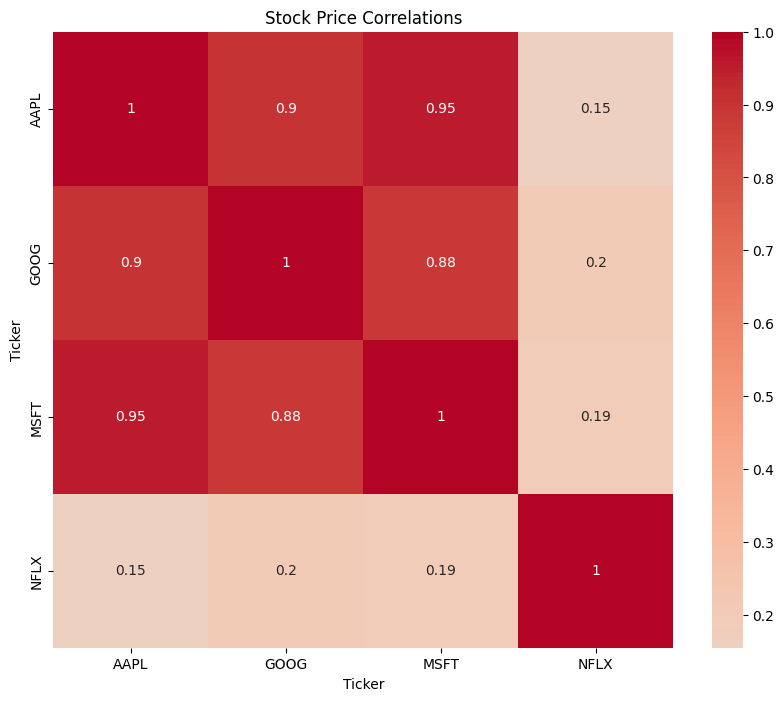

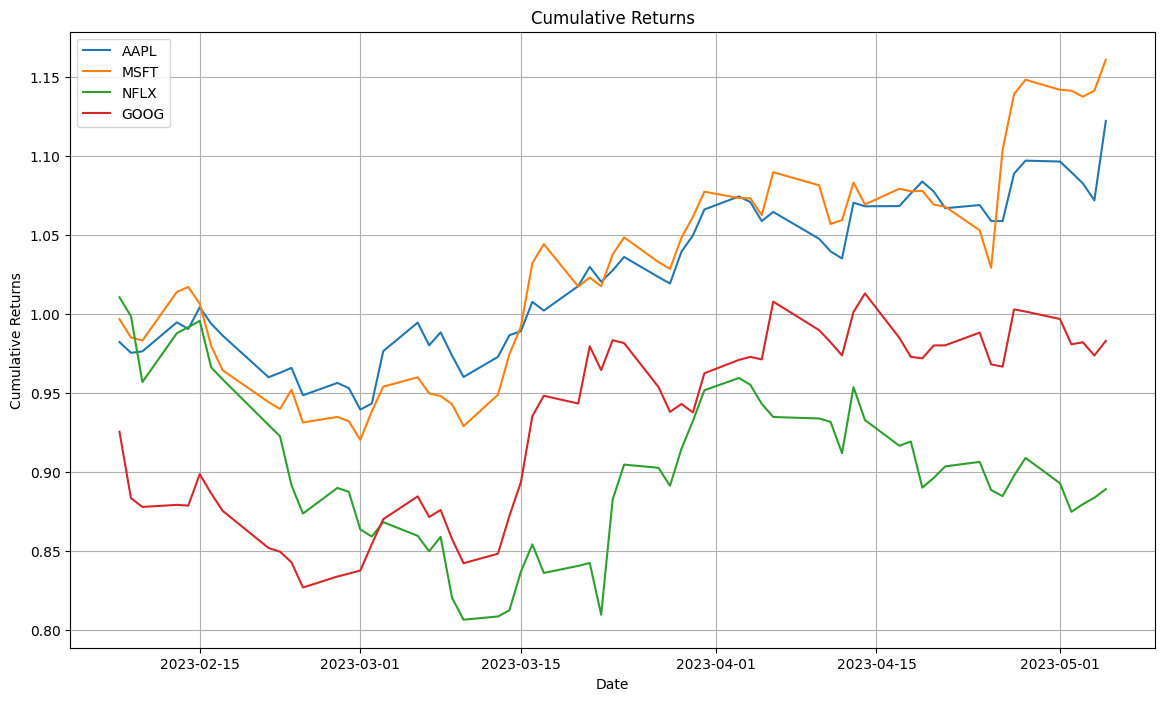

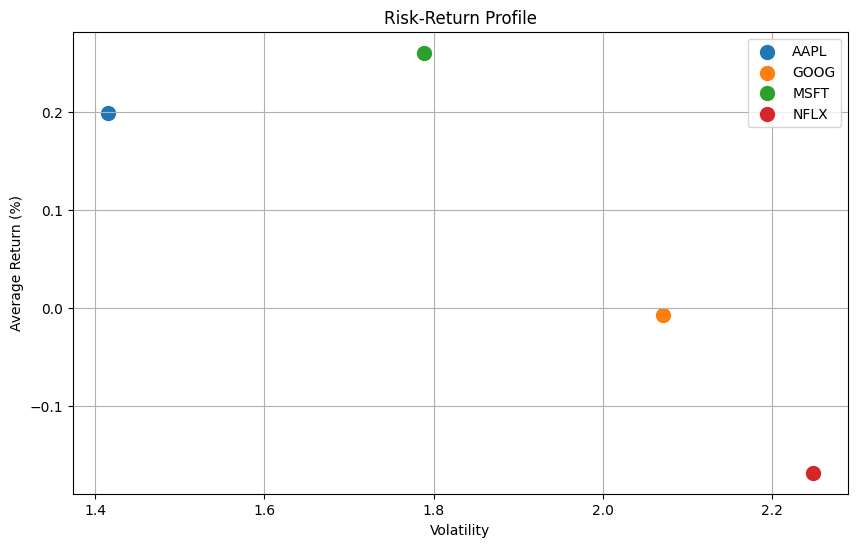

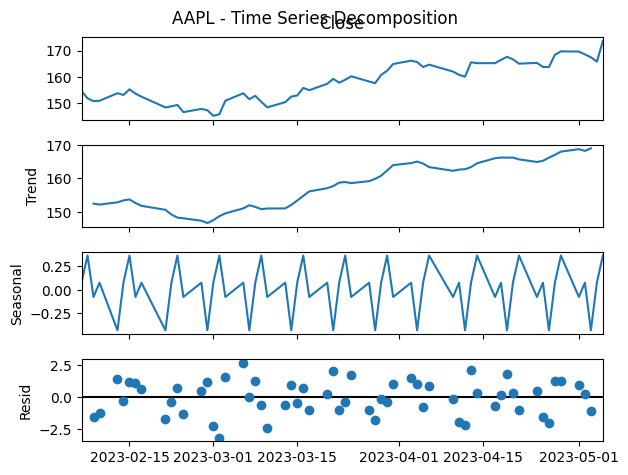

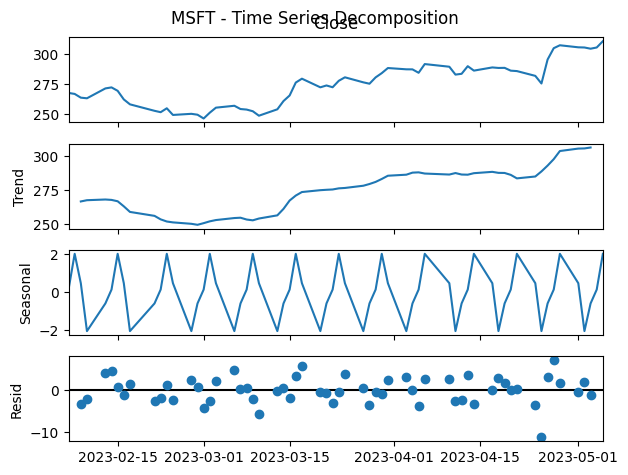

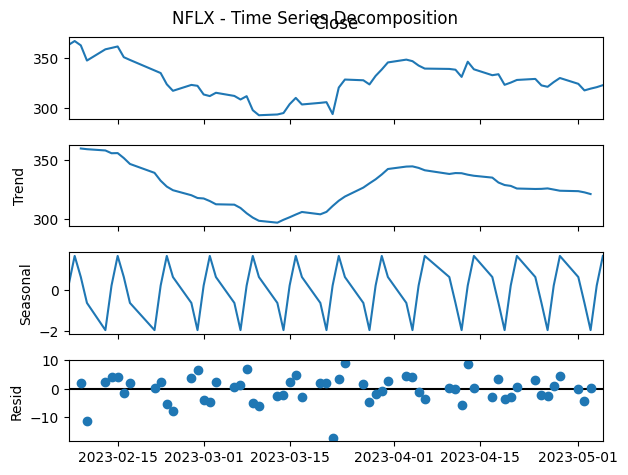

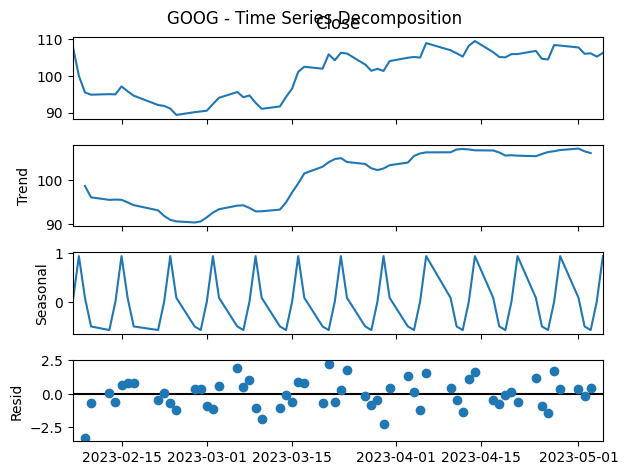


AAPL Return Prediction MSE: 2.6879


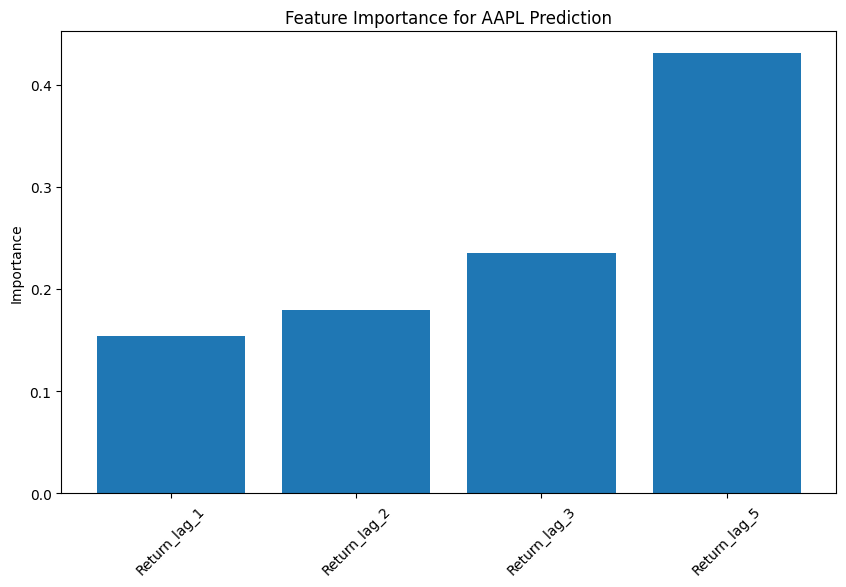

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load Data
df = pd.read_csv('stocks.csv')
df['Date'] = pd.to_datetime(df['Date'])
print("Companies in dataset:", df['Ticker'].unique())

# Data Cleaning
df.dropna(inplace=True)

# Price Trends
plt.figure(figsize=(14, 8))
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Close'], label=ticker)
plt.title('Stock Price Trends')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid()
plt.show()

# Feature Engineering
def calculate_daily_returns(group):
    group = group.copy()
    group['Daily_Return'] = group['Close'].pct_change() * 100
    return group

def calculate_moving_averages(group):
    group = group.copy()
    group['MA_7'] = group['Close'].rolling(window=7, min_periods=1).mean()
    group['MA_30'] = group['Close'].rolling(window=30, min_periods=1).mean()
    return group

df = df.groupby('Ticker', group_keys=False).apply(calculate_daily_returns)
df = df.groupby('Ticker', group_keys=False).apply(calculate_moving_averages)

# Volatility Calculation
volatility = df.groupby('Ticker')['Daily_Return'].std().sort_values(ascending=False)
print("\nVolatility:")
print(volatility)

# Moving Averages Plot
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker]
    plt.figure(figsize=(12, 6))
    plt.plot(ticker_data['Date'], ticker_data['Close'], label='Close Price')
    plt.plot(ticker_data['Date'], ticker_data['MA_7'], label='7-Day MA')
    plt.plot(ticker_data['Date'], ticker_data['MA_30'], label='30-Day MA')
    plt.title(f'{ticker} - Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid()
    plt.show()

# RSI Calculation
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].copy()
    ticker_data['RSI'] = calculate_rsi(ticker_data)
    plt.figure(figsize=(12, 6))
    plt.plot(ticker_data['Date'], ticker_data['RSI'], label='RSI')
    plt.axhline(70, color='r', linestyle='--')
    plt.axhline(30, color='g', linestyle='--')
    plt.title(f'{ticker} - RSI')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid()
    plt.show()

# Correlation Analysis
closing_prices = df.pivot(index='Date', columns='Ticker', values='Close')
correlation_matrix = closing_prices.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Stock Price Correlations')
plt.show()

# Cumulative Returns
plt.figure(figsize=(14, 8))
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].copy()
    ticker_data['Cumulative_Return'] = (1 + ticker_data['Daily_Return'] / 100).cumprod()
    plt.plot(ticker_data['Date'], ticker_data['Cumulative_Return'], label=ticker)
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

# Risk-Return Profile
performance = df.groupby('Ticker')['Daily_Return'].agg(['mean', 'std'])
performance.columns = ['Average Return', 'Volatility']
plt.figure(figsize=(10, 6))
for ticker in performance.index:
    plt.scatter(performance.loc[ticker, 'Volatility'], performance.loc[ticker, 'Average Return'], label=ticker, s=100)
plt.title('Risk-Return Profile')
plt.xlabel('Volatility')
plt.ylabel('Average Return (%)')
plt.legend()
plt.grid()
plt.show()

# Time Series Decomposition
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker].set_index('Date')
    if len(ticker_data) >= 5:
        result = seasonal_decompose(ticker_data['Close'], model='additive', period=5)
        result.plot()
        plt.suptitle(f'{ticker} - Time Series Decomposition')
        plt.show()

# Predictive Modeling (Example: AAPL)
aapl = df[df['Ticker'] == 'AAPL'].copy()
for lag in [1, 2, 3, 5]:
    aapl[f'Return_lag_{lag}'] = aapl['Daily_Return'].shift(lag)
aapl.dropna(inplace=True)

if not aapl.empty:
    X = aapl[['Return_lag_1', 'Return_lag_2', 'Return_lag_3', 'Return_lag_5']]
    y = aapl['Daily_Return']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f'\nAAPL Return Prediction MSE: {mse:.4f}')

    plt.figure(figsize=(10, 6))
    plt.bar(X.columns, model.feature_importances_)
    plt.title('Feature Importance for AAPL Prediction')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.show()
